# Welcome to the Thesis Notebook where measurements are pre-processed, cleaned, plotted and transformed
## Here, will be covered the measurements done using powerstat and the energy service + analyser service

In [172]:
import os
from pathlib import Path
import matplotlib.pyplot as plt
import pandas as pd
import re
import numpy as np
import csv



## Please modify root_path in order to switch experiments (idle or imaging)

## Convert to dataframe

In [183]:
import glob

csv_dir_idle = 'data/imaging_intervention/imaging_160/energy_logs' 
csv_dir_img = 'data/imaging_intervention/imaging_352/energy_logs'  # change if needed


# Pattern to match your energy_logs files
pattern_idle = os.path.join(csv_dir_idle, 'energy_logs_*.csv')
pattern_img = os.path.join(csv_dir_img, 'energy_logs_*.csv')

dataframes_idle = {}
dataframes_img = {}


# IDLE
for file_path in sorted(glob.glob(pattern_idle)):
    df_name = os.path.splitext(os.path.basename(file_path))[0]
    dataframes_idle[df_name] = pd.read_csv(file_path)

# for name, df in dataframes_idle.items():
    # print(f"DF IDLE: {name}: {len(df)} rows")

# IMG
for file_path in sorted(glob.glob(pattern_img)):
    df_name = os.path.splitext(os.path.basename(file_path))[0]
    dataframes_img[df_name] = pd.read_csv(file_path)

# for name, df in dataframes_img.items():
    # print(f"DF IMG: {name}: {len(df)} rows")




# Violin Plots for imaging and idle

/var/folders/87/xbc8k_k17_n921xhcp1k1hnc0000gn/T/ipykernel_63121/2529162831.py:25: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




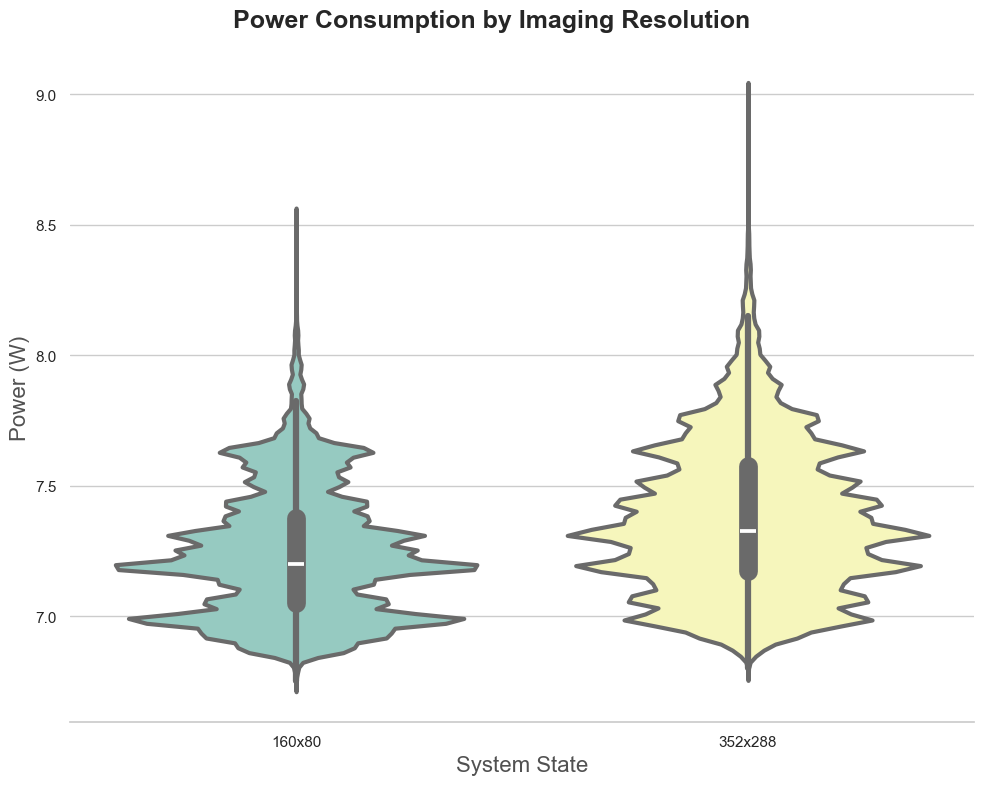

In [194]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Use consistent theme
sns.set(style="whitegrid")

# Step 1: Extract power values into a single DataFrame
def extract_power_from_dict(df_dict, label):
    power_values = []
    for df in df_dict.values():
        if 'power_watts' not in df.columns:
            raise KeyError("'power_watts' column not found.")
        power_values.extend(df['power_watts'].values)
    return pd.DataFrame({'Power (W)': power_values, 'State': label})

# Step 2: Create the combined DataFrame
idle_df = extract_power_from_dict(dataframes_idle, '160x80')
img_df = extract_power_from_dict(dataframes_img, '352x288')
combined_df = pd.concat([idle_df, img_df], ignore_index=True)

# Step 3: Create the plot
f, ax = plt.subplots(figsize=(10, 8))  # Wider format for clarity

sns.violinplot(
    x="State",
    y="Power (W)",
    data=combined_df,
    inner="box",
    palette="Set3",
    cut=2,
    linewidth=3
)

sns.despine(left=True)

# Step 4: Add titles and axis labels
f.suptitle('Power Consumption by Imaging Resolution', fontsize=18, fontweight='bold')
ax.set_xlabel("System State", size=16, alpha=0.8)
ax.set_ylabel("Power (W)", size=16, alpha=0.8)

plt.tight_layout()
plt.show()


In [185]:
print(len(set(combined_df['Power (W)'])))
print(combined_df['Power (W)'].nunique())


53
53


## PLOTS

### Here are plots for each individual run with their respective timestamps. Please check or change var of repetition for other runs

In [186]:
# import matplotlib.pyplot as plt

# # Loop through each DataFrame and generate a plot
# for name, df in dataframes.items():

#     # name_log = 'energy_logs_00'
#     df = dataframes[name]

#     # Extract relevant columns
#     time = df['timestamp']
#     current = df['current_amps']
#     voltage = df['supply_voltage']
#     power = df['power_watts']

#     # Plotting
#     plt.figure(figsize=(12, 6))
#     plt.plot(time, current, label='Current (A)')
#     plt.plot(time, voltage, label='Voltage (V)')
#     plt.plot(time, power, label='Power (W)')

#     plt.title(f"Energy Data Overview — {name}")
#     plt.xlabel("Timestamp")
#     plt.ylabel("Measurements")
#     plt.xticks(rotation=45)
#     plt.legend()
#     plt.tight_layout()
#     plt.show()
    

## Check power for imaging and idle

In [195]:
# IMAGING
total_power_img = 0

for name, df in dataframes_img.items():
    power = df['power_watts']
    average_power = power.mean()
    # print(f"Average Power for IMG {name}: {average_power:.2f} W")
    total_power_img += average_power

overall_average = total_power_img / len(dataframes_img)
print(f"\nOverall average power across all runs IMAGING: {overall_average:.2f} W")

# IDLE
total_power_idle = 0

for name, df in dataframes_idle.items():
    power = df['power_watts']
    average_power = power.mean()
    # print(f"Average Power for IDLE {name}: {average_power:.2f} W")
    total_power_idle += average_power

overall_average = total_power_idle / len(dataframes_idle)
print(f"\nOverall average power across all runs IDLE: {overall_average:.2f} W")




Overall average power across all runs IMAGING: 7.37 W

Overall average power across all runs IDLE: 7.24 W


# Delta for battery consumption for img and idle

In [197]:
def compute_voltage_drop(df_dict):
    # Get first and last DataFrames
    first_df = df_dict['energy_logs_00']
    last_df = df_dict['energy_logs_29']

    # Compute average voltage
    avg_v_first = first_df['supply_voltage'].mean()
    avg_v_last = last_df['supply_voltage'].mean()

    # Voltage drop
    delta_v = avg_v_first - avg_v_last

    return avg_v_first, avg_v_last, delta_v

# Run for both
v_first_idle, v_last_idle, delta_v_idle = compute_voltage_drop(dataframes_idle)
v_first_img, v_last_img, delta_v_img = compute_voltage_drop(dataframes_img)

# Print nicely
print(f"[IDLE]   V_start: {v_first_idle:.3f} V   V_end: {v_last_idle:.3f} V   Drop: {delta_v_idle:.3f} V")
print(f"[IMG]    V_start: {v_first_img:.3f} V   V_end: {v_last_img:.3f} V   Drop: {delta_v_img:.3f} V")


[IDLE]   V_start: 16.446 V   V_end: 15.992 V   Drop: 0.454 V
[IMG]    V_start: 16.300 V   V_end: 15.865 V   Drop: 0.435 V


# Powerstat.csv

# Convert to df for data and for summary of powerstat

In [198]:
import pandas as pd

def load_powerstat_csv(path):
    """
    Load and split a powerstat CSV file into:
    - data_df: detailed time-series measurements
    - summary_df: summary stats like average, stddev, etc.
    """
    with open(path, 'r') as f:
        lines = f.readlines()

    data_rows = []
    summary_rows = []
    capture_data = True

    for line in lines:
        line = line.strip()
        
        # Skip footer
        if line.startswith("Summary:") or line.startswith("System:"):
            continue
        
        # Detect table dividers (e.g., '--------')
        if re.match(r"^-{3,}", line):
            capture_data = False
            continue
        
        # Capture lines
        if capture_data and re.match(r"^\d{2}:\d{2}:\d{2}", line):
            data_rows.append(re.split(r"\s+", line))
        elif not capture_data and re.match(r"^(Average|GeoMean|StdDev|Minimum|Maximum)", line):
            summary_rows.append(re.split(r"\s+", line))

    # Define shared column headers
    columns = ["Time", "User", "Nice", "Sys", "Idle", "IO", "Run", "Ctxt/s", "IRQ/s", "Watts", "soc-th", "cpu-th"]

    # Create data DataFrame
    data_df = pd.DataFrame(data_rows, columns=columns)
    for col in data_df.columns[1:]:  # Skip 'Time'
        data_df[col] = pd.to_numeric(data_df[col], errors='coerce')

    # Create summary DataFrame
    summary_df = pd.DataFrame(summary_rows, columns=columns)
    for col in summary_df.columns[1:]:
        summary_df[col] = pd.to_numeric(summary_df[col], errors='coerce')

    return data_df, summary_df


### Call function for csv files

In [210]:
state = 'idle'  # or 'idle'

# Define your paths
# before_path = f"data/before_intervention/battery_1min_600Hz({state})/powerstat.csv"
# powersave_path = f"data/powersave_intervention/battery_1min_600Hz({state})/powerstat.csv"
# conservative_path = f"data/conservative_intervention/battery_1min_600Hz({state})/powerstat.csv"

three_path = 'data/imaging_intervention/imaging_352/powerstat.csv' # 352x288
one_path = 'data/imaging_intervention/imaging_160/powerstat.csv' # 160x80
six_path = 'data/before_intervention/battery_1min_600Hz(img)/powerstat.csv' # 640x480

three_data, three_summary = load_powerstat_csv(three_path)
one_data, one_summary = load_powerstat_csv(before_path)
six_data, six_summary = load_powerstat_csv(six_path)    


# Load each file
# before_data, before_summary = load_powerstat_csv(before_path)
# powersave_data, powersave_summary = load_powerstat_csv(powersave_path)
# conservative_data, conservative_summary = load_powerstat_csv(conservative_path)

# before_data
# before_summary

# powersave_data
# powersave_summary

# conservative_data
# conservative_summary
three_data['cpu-th']

0       45.0
1       45.0
2       45.0
3       45.0
4       45.0
        ... 
4565    46.0
4566    46.0
4567    47.0
4568    46.0
4569    46.0
Name: cpu-th, Length: 4570, dtype: float64

## Plot Temperatures against Time: CPU-th, SOC-th

## Plot temp for the 2 different resolutions

In [207]:
import pandas as pd
import matplotlib.pyplot as plt

def preprocess_relative_cpu_temp(df, label):
    # Convert Time to datetime
    df = df.copy()
    df['Time'] = pd.to_datetime(df['Time'], format='%H:%M:%S')

    # Calculate relative time in minutes
    t0 = df['Time'].iloc[0]
    df['ElapsedMin'] = (df['Time'] - t0).dt.total_seconds() // 60  # integer minutes

    # Group by elapsed minute and compute mean CPU temperature
    temp_df = df.groupby('ElapsedMin')['cpu-th'].mean().reset_index()
    temp_df['Governor'] = label
    return temp_df

# Preprocess two datasets
three_cpu = preprocess_relative_cpu_temp(three_data, '352x288')
one_cpu = preprocess_relative_cpu_temp(one_data, '160x80')

# Combine into one dataframe
cpu_df_all = pd.concat([three_cpu, one_cpu])


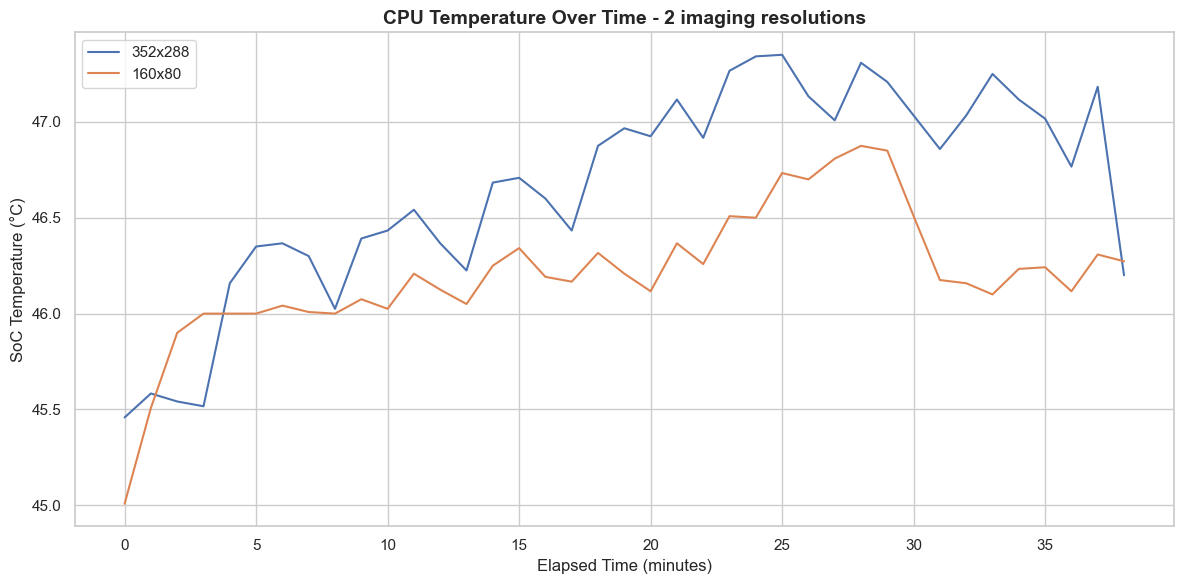

In [208]:
plt.figure(figsize=(12, 6))
for gov in cpu_df_all['Governor'].unique():
    gov_data = cpu_df_all[cpu_df_all['Governor'] == gov]
    plt.plot(gov_data['ElapsedMin'], gov_data['cpu-th'], label=gov)

plt.title("CPU Temperature Over Time - 2 imaging resolutions", fontsize=14, weight='bold')
plt.xlabel("Elapsed Time (minutes)")
plt.ylabel("SoC Temperature (°C)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Plot temp for 3 scenarios

In [211]:
import pandas as pd
import matplotlib.pyplot as plt

def preprocess_relative_cpu_temp(df, label):
    # Convert Time to datetime
    df = df.copy()
    df['Time'] = pd.to_datetime(df['Time'], format='%H:%M:%S')

    # Calculate relative time in seconds
    t0 = df['Time'].iloc[0]
    df['ElapsedMin'] = (df['Time'] - t0).dt.total_seconds() // 60  # integer minutes

    # Group by elapsed minute and compute mean CPU temperature
    temp_df = df.groupby('ElapsedMin')['cpu-th'].mean().reset_index()
    temp_df['Governor'] = label
    return temp_df

# Preprocess all three datasets
six_cpu = preprocess_relative_cpu_temp(six_data, '640x480')
three_cpu = preprocess_relative_cpu_temp(three_data, '352x288')
one_cpu = preprocess_relative_cpu_temp(one_data, '160x80')

# Combine into one dataframe
cpu_df_all = pd.concat([six_cpu, three_cpu, one_cpu])


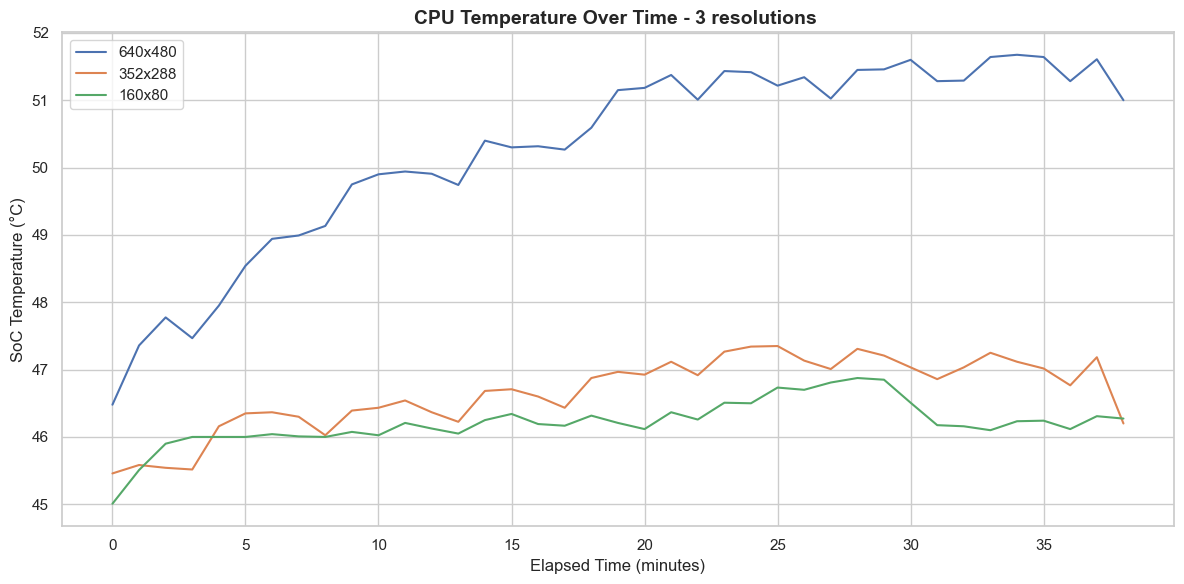

In [214]:
# Plot
plt.figure(figsize=(12, 6))
for gov in cpu_df_all['Governor'].unique():
    gov_data = cpu_df_all[cpu_df_all['Governor'] == gov]
    plt.plot(gov_data['ElapsedMin'], gov_data['cpu-th'], label=gov)

plt.title("CPU Temperature Over Time - 3 resolutions ", fontsize=14, weight='bold')
plt.xlabel("Elapsed Time (minutes)")
plt.ylabel("SoC Temperature (°C)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## 3D Plots

## Compute average measurements for all logs for each repetition and plot a line chart 
Each repetition 0,1,2 .. has multiple measurements. Here, I compute the average of the measurements per repetition and I plot based on those averages

In [209]:
# Group by repetition and compute mean for voltage, current, and power
avg_per_run = df.groupby("repetition")[["voltage", "current", "power"]].mean().reset_index()
avg_per_run.head()

KeyError: 'repetition'

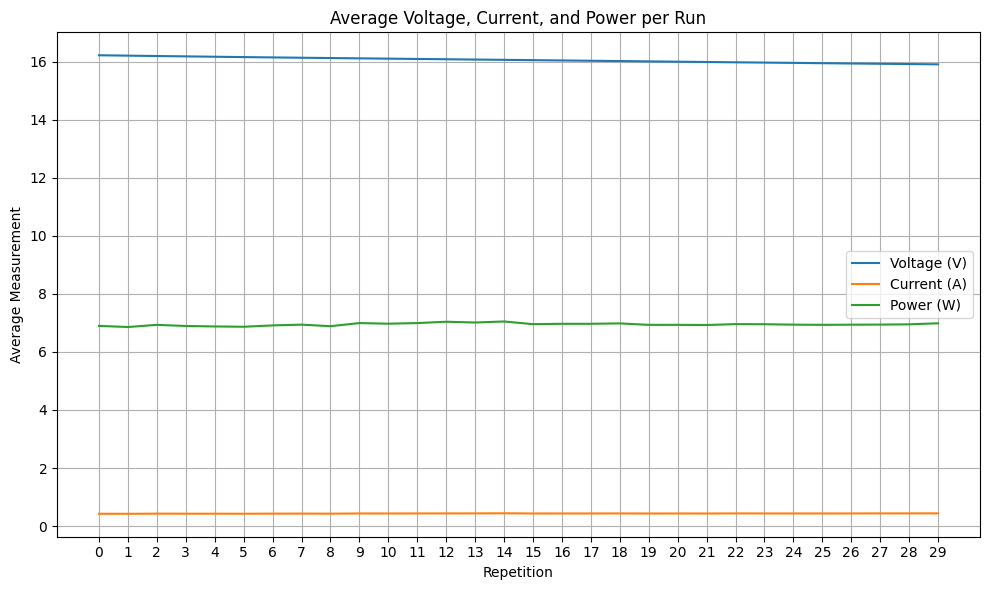

In [23]:
plt.figure(figsize=(10, 6))

plt.plot(avg_per_run["repetition"], avg_per_run["voltage"], label="Voltage (V)")
plt.plot(avg_per_run["repetition"], avg_per_run["current"], label="Current (A)")
plt.plot(avg_per_run["repetition"], avg_per_run["power"], label="Power (W)")

plt.title("Average Voltage, Current, and Power per Run")
plt.xlabel("Repetition")
plt.ylabel("Average Measurement")
plt.xticks(avg_per_run["repetition"])  # Show all run numbers
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


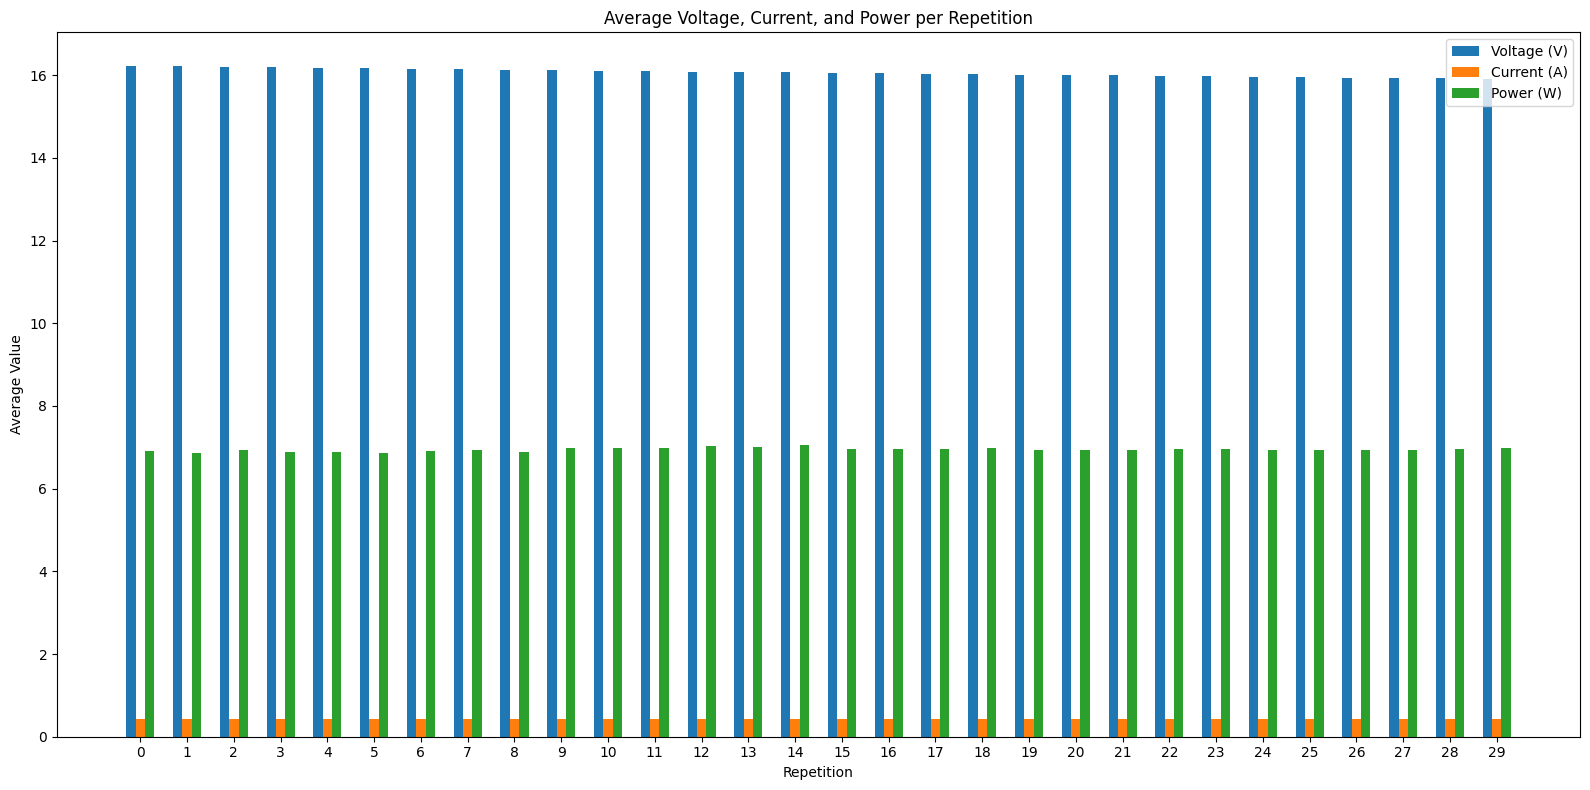

In [24]:
# 2. Create X locations
reps = avg_per_run["repetition"].values
space = 3
x = np.arange(len(reps)) * space  # positions on x-axis

# 3. Set bar width
width = 0.6

# 4. Plot bars for each metric
plt.figure(figsize=(16, 8))
plt.bar(x - width, avg_per_run["voltage"], width, label="Voltage (V)", color="tab:blue")
plt.bar(x,         avg_per_run["current"], width, label="Current (A)", color="tab:orange")
plt.bar(x + width, avg_per_run["power"],   width, label="Power (W)",   color="tab:green")

# 5. Add labels and formatting
plt.xlabel("Repetition")
plt.ylabel("Average Value")
plt.title("Average Voltage, Current, and Power per Repetition")
plt.xticks(x, reps)
plt.legend()
# plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

## Average per experiment
Now, I take the average of the entire repetitions and compute only one value per variable. Average voltage, current and power

In [20]:
overall_avg = df[["voltage", "current", "power"]].mean()
display(overall_avg)


voltage    16.061876
current     0.431888
power       6.947625
dtype: float64